In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARMA
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from sklearn import linear_model

df=pd.read_excel("Complete-dataset-FINAL.xlsx")

### Note
Dit model is een alternatief voor de lineare regressie model. De algemene bunsiness & data understanding zijn te vinden in de Jupyter notebook van de lineare regressie. In deze notebook zal er gefocust worden op het voorspellingsmodel (ARIMA model).

# Business understanding
We gaan het ARIMA model gebruiken. Hier gaan we kijken of de data stationair is, wat betekent dat een tijdsreeks niet afhankelijk is van tijd. Eerst zullen de parameters voor het ARIMA model worden bepaald. ARIMA(p=?, d=?,q=?)

### ARIMA model
Het doel van een ARIMA model is het nabootsen van een tijdsserie. Dit wordt gedaan door de variaties in de data te modelleren door middel van de volgende drie opties: 

- AR (auto-regressief), voorgaande waardes worden gebruikt om nieuwe waardes te voorspellen.
- I (integrated), niet de originele serie maar een gedifferentieerde tijdsserie wordt gebruikt. Dit om de tijdsserie stationair te maken. 
- MA (moving average), voorafgaande fouten worden gebruikt om nieuwe fouten voorspellen. Dit heeft een smoothing effect, een bewegend gemiddelde. 

Door deze effecten te mengen kun je de meeste tijdsseries nabootsen. In de volgende sectie gaan we de effecten van de AR en MA termen op een tijdsserie bekijken. 



# Data preparation

In [133]:
df=df.dropna()
df.columns = df.columns.str.replace('Total Error', 'Total')
df.columns

Index(['Method name', 'N (no. labs)', 'Mean', 'Bias', 'CV', 'Sample',
       'Reference Value', 'Year', 'Source (CAP/EurA1c)', 'Type (Fresh/frozen)',
       'Manufacturer', 'Total'],
      dtype='object')

In [134]:
list_top10 = df['Manufacturer'].value_counts()[:10].index.tolist()
top10_manufacturers = df.loc[df['Manufacturer'].isin(list_top10)]
top10_manufacturers['Manufacturer'].value_counts()


Siemens              918
Bio-Rad              667
Roche Diagnostics    605
Beckman Coulter      349
Tosoh                284
Abbott               278
Sebia                201
Trinity Biotech      185
Vitros               139
Alere                111
Name: Manufacturer, dtype: int64

In [135]:
# manufacturers = df.groupby("Manufacturer")
manufacturers = top10_manufacturers.groupby("Manufacturer")
manufacturers.size().nlargest(20)

Manufacturer
Siemens              918
Bio-Rad              667
Roche Diagnostics    605
Beckman Coulter      349
Tosoh                284
Abbott               278
Sebia                201
Trinity Biotech      185
Vitros               139
Alere                111
dtype: int64

In [136]:
top10_manufacturers = top10_manufacturers.dropna()
# top10_manufacturers=top10_manufacturers[['Manufacturer', 'Total', 'Year']]
top10_manufacturers=top10_manufacturers[['Manufacturer', 'Total']]
top10_manufacturers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3737 entries, 0 to 4683
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Manufacturer  3737 non-null   object 
 1   Total         3737 non-null   float64
dtypes: float64(1), object(1)
memory usage: 87.6+ KB


In [137]:
# sns.lineplot(x="Year", y="Total",
#              hue="Manufacturer", 
#              data=top10_manufacturers)

# Modeling

#model regressie trainen en testen
#R2 zegt iets over de bruikbaarheid van je model
traindata, testdata = train_test_split(Siemens, train_size=0.65, test_size=0.35, random_state=42)

#eerst afhankelijke variabele, dus hierbij 'Manufacturer'
mod1 = ols(formula='Year ~ Total', data=traindata).fit()
print(mod1.summary())

In [138]:
# traindata, testdata = train_test_split(df, train_size=0.65, test_size=0.35, random_state=42)

# X_train, X_test, Y_train, Y_test = train_test_split(df["Year"].values, df["Manufacturer"].values, test_size = .20, random_state = 40)
top10_manufacturers= top10_manufacturers.dropna()


In [139]:
# Check for stationarity of the time-series data
# We will look for p-value. In case, p-value is less than 0.05, the time series data can said to have stationarity
from statsmodels.tsa.stattools import adfuller
manufacturers = top10_manufacturers.groupby("Manufacturer")
List_meetmethoden = []


#AIC input is to compute the optimal number iteratively.
for name, data in manufacturers: 
    data= data.dropna()
    print(name) 
    df_stationarityTest = adfuller(data['Total'], autolag='AIC')    
    print("\n")
    print(f'ADF Statistic: {df_stationarityTest[0]}')
    print(f'n_lags: {df_stationarityTest[1]}')
    print(f'p-value: {df_stationarityTest[1]}')
    for key, value in df_stationarityTest[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')    

    
    if df_stationarityTest[1] > 0.05:
        List_meetmethoden.append(name)
    print("\n")

print("Meetmethoden met een p-waarden van boven de 0.05:")
List_meetmethoden

Abbott


ADF Statistic: -1.9898120102862134
n_lags: 0.29105796634827763
p-value: 0.29105796634827763
Critial Values:
   1%, -3.4554613060274972
Critial Values:
   5%, -2.8725931472675046
Critial Values:
   10%, -2.5726600403359887


Alere


ADF Statistic: -4.340042847938978
n_lags: 0.0003783913537194656
p-value: 0.0003783913537194656
Critial Values:
   1%, -3.49181775886872
Critial Values:
   5%, -2.8884437992971588
Critial Values:
   10%, -2.5811201893779985


Beckman Coulter


ADF Statistic: -3.2663735133490923
n_lags: 0.016450142108014498
p-value: 0.016450142108014498
Critial Values:
   1%, -3.4495033946549123
Critial Values:
   5%, -2.8699787979596136
Critial Values:
   10%, -2.5712658305164955


Bio-Rad


ADF Statistic: -5.086968935872926
n_lags: 1.4889943958397245e-05
p-value: 1.4889943958397245e-05
Critial Values:
   1%, -3.4405132737812596
Critial Values:
   5%, -2.8660244429195725
Critial Values:
   10%, -2.5691581552588447


Roche Diagnostics


ADF Statistic: -2.4792452298597

['Abbott', 'Roche Diagnostics']

### Analyse van p-values
Een p-value van 0.05 of er onder ligt, betekent dat de data stationair is. De resultaten laten zien dat bij sommige de meetmethoden de data niet stationair is. Dit betekent dat bij deze meetmethoden nullhypothese (voorspelt geen effect of relatie) mogelijk van toepassing is.
Om deze meetmethoden stationair te maken, wordt het gedifferentieerd. 

#### Differentiatie van meetmethoden met p-value > 0.05

In [140]:
#Één keer diffrentiëren
for name, data in manufacturers:
    if name in List_meetmethoden:
        print("\n" + name) 
        df_stationarityTest = adfuller(data['Total'].diff().dropna(), autolag='AIC')    
        print("")
        print(f'ADF Statistic: {df_stationarityTest[0]}')
        print(f'n_lags: {df_stationarityTest[1]}')
        print(f'p-value: {df_stationarityTest[1]}')
        for key, value in df_stationarityTest[4].items():
            print('Critial Values:')
            print(f'   {key}, {value}')    

        


Abbott

ADF Statistic: -5.469566816634822
n_lags: 2.4157069378753383e-06
p-value: 2.4157069378753383e-06
Critial Values:
   1%, -3.4554613060274972
Critial Values:
   5%, -2.8725931472675046
Critial Values:
   10%, -2.5726600403359887

Roche Diagnostics

ADF Statistic: -11.397196142263832
n_lags: 7.805836700751158e-21
p-value: 7.805836700751158e-21
Critial Values:
   1%, -3.4414256033746606
Critial Values:
   5%, -2.8664262627821473
Critial Values:
   10%, -2.569372254520843


In [141]:
#2x diff = I (ARIMA)
for name, data in manufacturers:
    if name in List_meetmethoden:
        print("\n")
        print(name) 
        # data['Total'].diff().diff().plot(figsize=(16,10))
        # plt.show()
        data_diff = data['Total'].diff().diff().dropna()
        
        df_stationarityTest = adfuller(data_diff, autolag='AIC')    

        print(f'ADF Statistic: {df_stationarityTest[0]}')
        print(f'n_lags: {df_stationarityTest[1]}')
        print(f'p-value: {df_stationarityTest[1]}')
        for key, value in df_stationarityTest[4].items():
            print('Critial Values:')
            print(f'   {key}, {value}')    




Abbott
ADF Statistic: -8.002101000544423
n_lags: 2.319181934104945e-12
p-value: 2.319181934104945e-12
Critial Values:
   1%, -3.4556556713934934
Critial Values:
   5%, -2.872678352489859
Critial Values:
   10%, -2.57270548832225


Roche Diagnostics
ADF Statistic: -12.62780788192685
n_lags: 1.5279897917157498e-23
p-value: 1.5279897917157498e-23
Critial Values:
   1%, -3.4415584920942424
Critial Values:
   5%, -2.866484781324317
Critial Values:
   10%, -2.569403436033035



# Conclusie p-waarden
Hier is te zien dat bij 2 keer differentiëren dat de p-waarden juist groter worden. Voor het ARIMA model wordt de kleinste p-waarde gebruikt. Daarom nemen we 0 als parameter bij alle meetmethoden. Dus ARIMA(p=?,d=0,q=?)

# Data preparation ACF & PACF

### ACF plot

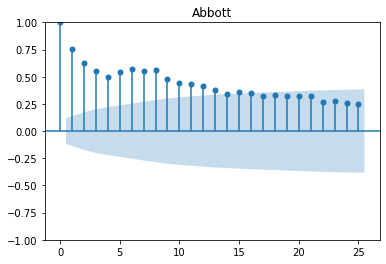

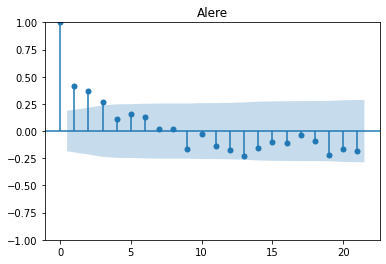

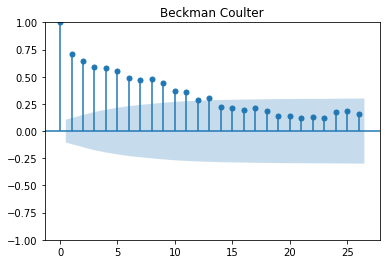

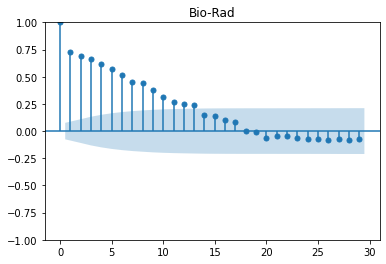

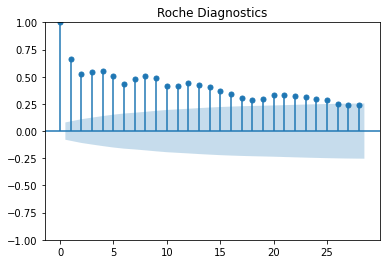

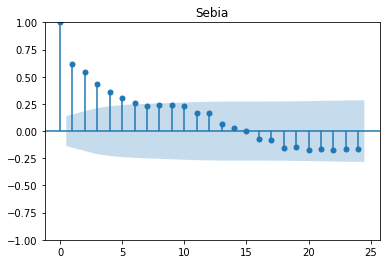

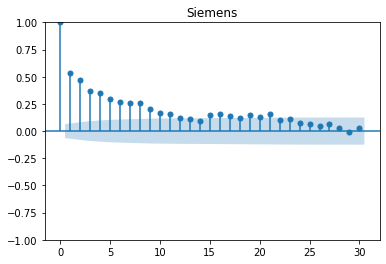

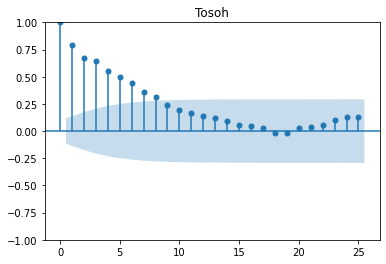

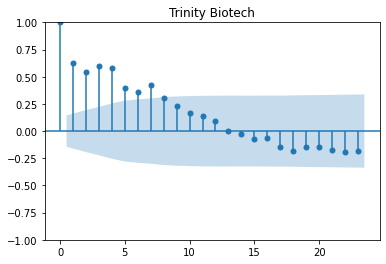

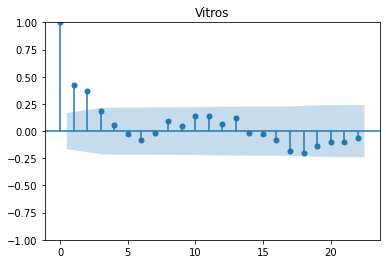

In [142]:
from statsmodels.graphics.tsaplots import plot_acf
for name, data in manufacturers: 
    acf =plot_acf(data['Total'], title=name, alpha=.05)
    

### Analyse van ACF plot
In dit autocorrelatieplot liggen bijna alle waardes niet binnen het lichtblauwe onzekerheidsgebied (deze variantie in autocorrelatie kan mogelijk worden verklaard door ruis). Dit betekent dat we juist wel MA-parameter moeten in te stellen (datapunten buiten het onzekerheidgebied).
Per methode is er een andere MA waarden. 

In [143]:
Lijst_MA = [13,2,11,13,26,5,15,8,7,2]

C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.w

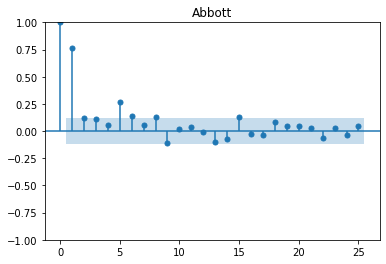

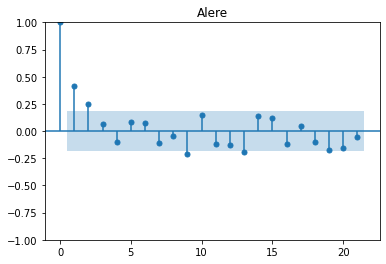

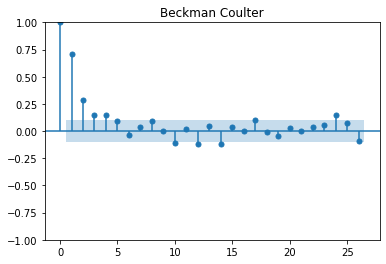

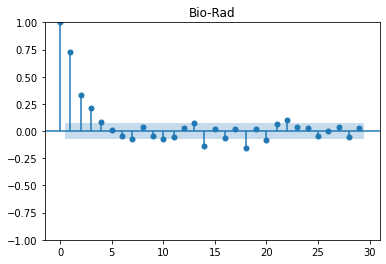

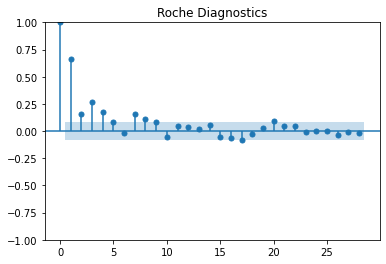

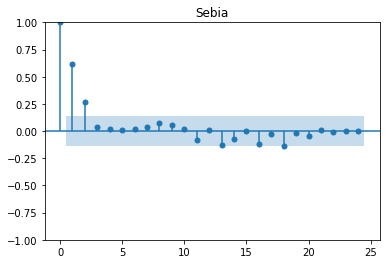

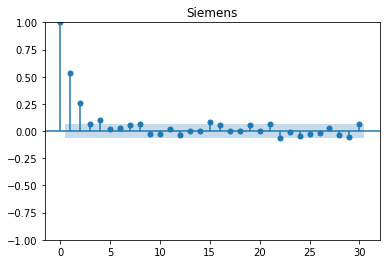

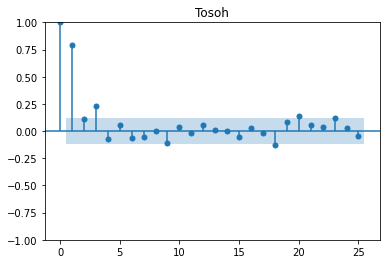

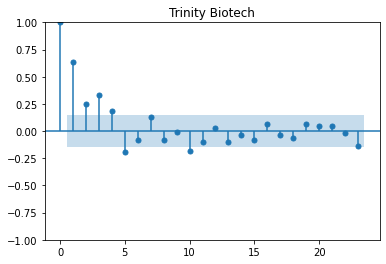

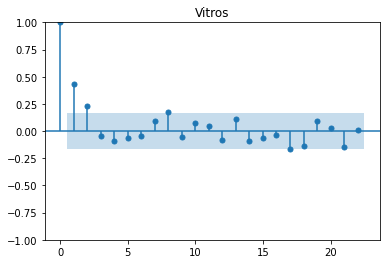

In [144]:
from statsmodels.graphics.tsaplots import plot_pacf

for name, data in manufacturers: 
    pacf = plot_pacf(data['Total'], title=name)

### Analyse van pacf plot
De partiële autocorrelatie geeft weer hoe sterk het verband is tussen de waarde van een lag en de waarde van voorgaande lags. Als er tussen de lags nog significante correlatie bestaat is dit een aanwijzing dat er auto-correlatie optreed en dat het instellen van de AR parameter een goed idee is.

Bij alle grafieken is te zien dat de eerste lag het meest significant is. Daarom nemen we p met de waarde 1. Dus ARIMA(p=1,d=0,q=lijst_MA)

# ARIMA modeling

In [147]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm


In [148]:
counter= 0
ARIMA_data = top10_manufacturers['Total', 'Year']
# for name, data in manufacturers:
#     print(name)
#     data.index = pd.DatetimeIndex(data.index).to_period('M')

#     model = sm.tsa.arima.ARIMA(data['Total'], order=(0,2,Lijst_MA[counter]))
#     model_fit = model.fit()
#     print(model_fit.summary())
#     # fig = model_fit.plot_predict('2022',dynamic=False)
#     counter = counter + 1 
#     break

from statsmodels.tsa.arima.model import ARIMA

model = sm.tsa.arima.ARIMA(ARIMA_data, order=(1,0,Lijst_MA[counter]))
model_fit = model.fit()
print(model_fit.summary())

fig, ax = plt.subplots()
ax = ARIMA_data.iloc['2009.0':].plot(ax=ax)
fig = model_fit.plot_predict('2020.0', '2025.0', ax=ax)
fig.show()
#P>|z| significant? onder 0.01

KeyError: ('Total', 'Year')

In [ ]:
# Actual vs Fitted
model_fit.plot_predict('2009.0', '2021.0',dynamic=False)
# model_fit.plot_predict(start,end,dynamic=False)

plt.show()


AttributeError: 'ARIMAResults' object has no attribute 'plot_predict'